# Satellite image classification using VGG 19

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG19
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

In [25]:
# Global parameters
image_size = 256
train_folder = "Images/train/"
test_folder = "Images/test/"
train_batchsize = 64
val_batchsize = 16

In [26]:
def create_model_with_additional_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionresnetV2":
        pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "mobilenet":
        pretrained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # Freeze all the layers
    for layer in pretrained_model.layers[:]:
        layer.trainable = False
    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)
    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [27]:
def create_model_with_retrainable_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers
    for layer in pretrained_model.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)

    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [28]:
def train_model(model, train_folder, test_folder, train_batchsize, val_batchsize, image_size, filename,
                epochs = 3,classmode='categorical', lr=1e-4):
    # No Data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Data Generator for Training data
    train_generator = train_datagen.flow_from_directory(
            train_folder,
            target_size=(image_size, image_size),
            batch_size=train_batchsize,
            class_mode=classmode)

    # Data Generator for Validation data
    validation_generator = validation_datagen.flow_from_directory(
            test_folder,
            target_size=(image_size, image_size),
            batch_size=val_batchsize,
            class_mode=classmode,
            shuffle=False)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=lr),
                  metrics=['acc'])

    # Train the Model
    history = model.fit_generator(
      train_generator, train_generator.n // train_batchsize, epochs=epochs, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // val_batchsize)

    # Save the Model
    model.save(filename)
    return model, history

In [29]:
def plot_training_process(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [30]:
from random import randint

def show_result(model, test_folder, image_size, classmode='categorical'):
    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    # Create a generator for prediction
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the label to class mapping from the generator
    label2index = validation_generator.class_indices

    # Getting the mapping from class index to class label
    idx2label = dict((v, k) for k, v in label2index.items())

    # Get the predictions from the model using the generator
    predictions = model.predict_generator(validation_generator,
                                          steps=validation_generator.samples / validation_generator.batch_size,
                                          verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

    # Show the errors
    for i in range(5):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_folder, fnames[errors[i]]))
        plt.figure(figsize=[7, 7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

# Experiment 1. Create model with VGG 19 imagenet weights and add 3 more layers

In [31]:
model_vgg19 = create_model_with_additional_layers(model_name="vgg19", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f16b4110240> False
<keras.layers.convolutional.Conv2D object at 0x7f16b41100b8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4af3278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1881b48208> False
<keras.layers.convolutional.Conv2D object at 0x7f16b40e6ba8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b40f9e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b408c4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f16b40b57b8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b40b5048> False
<keras.layers.convolutional.Conv2D object at 0x7f16b405e630> False
<keras.layers.convolutional.Conv2D object at 0x7f16b400acf8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b40396a0> False
<keras.layers.convolutional.Conv2D object at 0x7f169c7cccf8> False
<keras.layers.convolutional.Conv2D object at 0x7f169c7e3fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f169c7f75f8> Fa

In [32]:
model_trained_vgg19, history_vgg19 = train_model(model=model_vgg19, train_folder=train_folder, test_folder=test_folder,
            train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size, filename="vgg19.h5",
                                         lr=1e-5, epochs=20)

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
106/106 [==============================] - 76s 720ms/step - loss: 2.1336 - acc: 0.3897 - val_loss: 1.3707 - val_acc: 0.7350
Epoch 2/20
106/106 [==============================] - 75s 712ms/step - loss: 1.1386 - acc: 0.6975 - val_loss: 0.9512 - val_acc: 0.7881
Epoch 3/20
106/106 [==============================] - 75s 709ms/step - loss: 0.7946 - acc: 0.7903 - val_loss: 0.7474 - val_acc: 0.8225
Epoch 4/20
106/106 [==============================] - 76s 714ms/step - loss: 0.6137 - acc: 0.8349 - val_loss: 0.6283 - val_acc: 0.8356
Epoch 5/20
106/106 [==============================] - 77s 722ms/step - loss: 0.4993 - acc: 0.8677 - val_loss: 0.5587 - val_acc: 0.8544
Epoch 6/20
106/106 [==============================] - 76s 714ms/step - loss: 0.4191 - acc: 0.8886 - val_loss: 0.5417 - val_acc: 0.8519
Epoch 7/20
106/106 [==============================] - 74s 701ms/step - loss: 0.3585 - acc: 0.9066 - val_

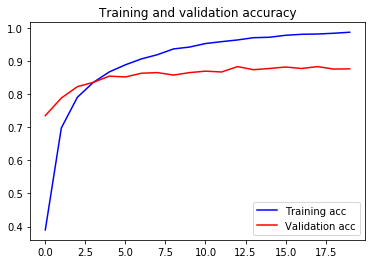

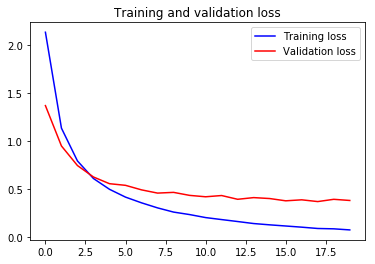

In [33]:
plot_training_process(history=history_vgg19)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 15s 148ms/step
No of errors = 198/1600


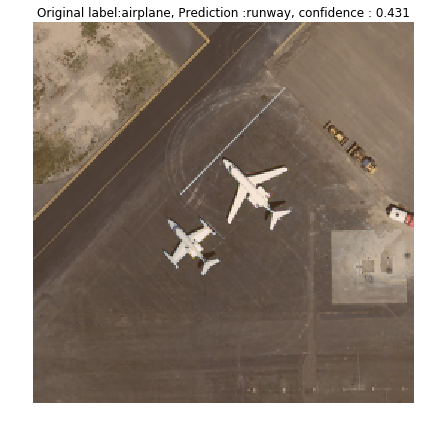

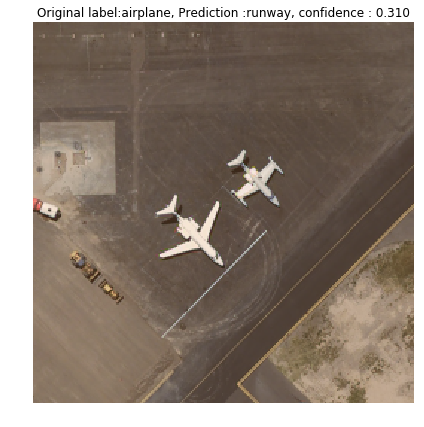

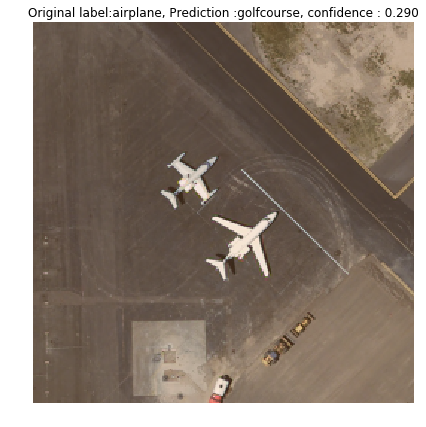

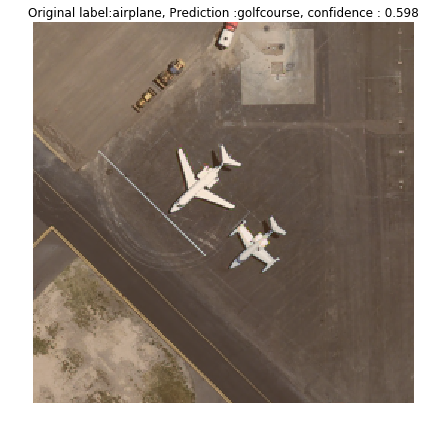

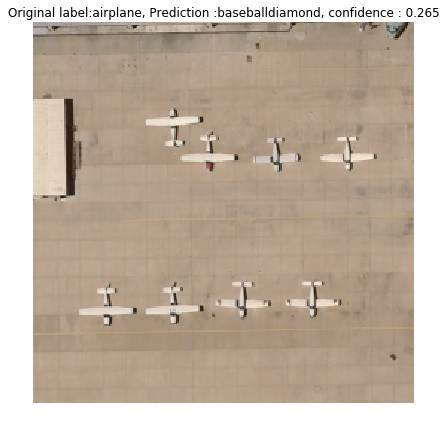

In [34]:
show_result(model_trained_vgg19, test_folder=test_folder, image_size=image_size)

# Experiment 2. Retrain last 4 layers

In [35]:
model_vgg19_retrainable_layers = create_model_with_retrainable_layers("vgg19", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f16b4a1c128> False
<keras.layers.convolutional.Conv2D object at 0x7f169c12e0b8> False
<keras.layers.convolutional.Conv2D object at 0x7f169c01ad68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f169c06d780> False
<keras.layers.convolutional.Conv2D object at 0x7f168d7d7198> False
<keras.layers.convolutional.Conv2D object at 0x7f168d7d7b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f168d7ed630> False
<keras.layers.convolutional.Conv2D object at 0x7f168d798a90> False
<keras.layers.convolutional.Conv2D object at 0x7f168d7add30> False
<keras.layers.convolutional.Conv2D object at 0x7f168d73d3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f168d7665c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f168d713c88> False
<keras.layers.convolutional.Conv2D object at 0x7f168d6bf198> False
<keras.layers.convolutional.Conv2D object at 0x7f168d6bfcc0> False
<keras.layers.convolutional.Conv2D object at 0x7f168d6e9f98> Fa

In [38]:
model_trained_vgg19_retrainable_layers, history_vgg19_retrainable_layers = train_model(epochs=20, lr=1e-5, model=model_vgg19_retrainable_layers, train_folder=train_folder,
            test_folder=test_folder, train_batchsize=50, val_batchsize=10, image_size=image_size,
                                                     filename="vgg19_lats4.h5")

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
136/136 [==============================] - 85s 625ms/step - loss: 0.1824 - acc: 0.9379 - val_loss: 0.4682 - val_acc: 0.8706
Epoch 2/20
136/136 [==============================] - 82s 606ms/step - loss: 0.1069 - acc: 0.9635 - val_loss: 0.4084 - val_acc: 0.8763
Epoch 3/20
136/136 [==============================] - 84s 615ms/step - loss: 0.0757 - acc: 0.9771 - val_loss: 0.3713 - val_acc: 0.8925
Epoch 4/20
136/136 [==============================] - 83s 609ms/step - loss: 0.0528 - acc: 0.9840 - val_loss: 0.4120 - val_acc: 0.8819
Epoch 5/20
136/136 [==============================] - 82s 605ms/step - loss: 0.0409 - acc: 0.9876 - val_loss: 0.4188 - val_acc: 0.8919
Epoch 6/20
136/136 [==============================] - 82s 606ms/step - loss: 0.0249 - acc: 0.9935 - val_loss: 0.5071 - val_acc: 0.8819
Epoch 7/20
136/136 [==============================] - 82s 606ms/step - loss: 0.0180 - acc: 0.9949 - val_

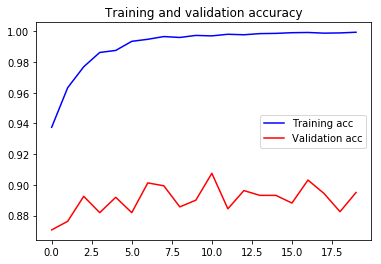

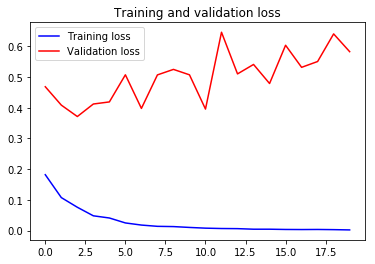

In [39]:
plot_training_process(history_vgg19_retrainable_layers)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 15s 147ms/step
No of errors = 168/1600


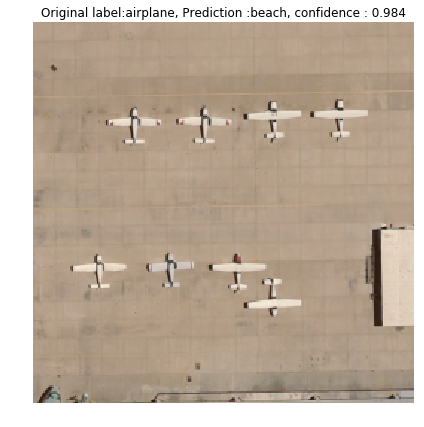

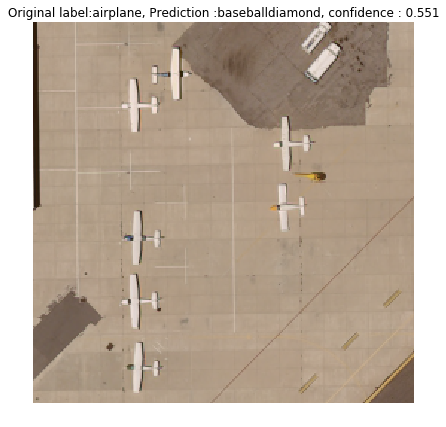

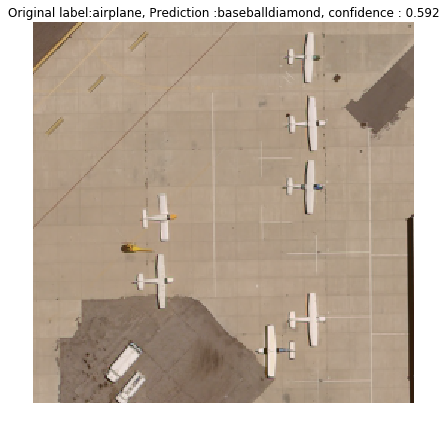

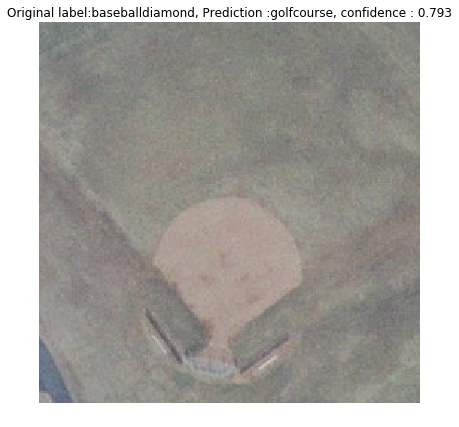

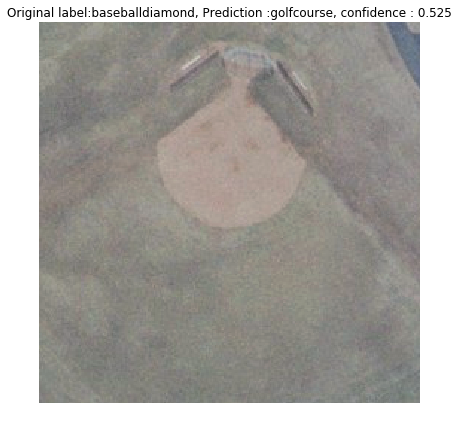

In [40]:
show_result(model=model_trained_vgg19_retrainable_layers, image_size=image_size, test_folder=test_folder)